In [175]:
#base libraries
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from timeit import default_timer as timer
from pprint import pprint 
from time import time
import copy
from pathlib import Path
import datetime

from sklearn.metrics import mean_squared_log_error
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor

from tqdm import tqdm_notebook as tqdm
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import statsmodels.api as sm

#other visualizations
import chart_studio.plotly as py
import plotly.graph_objs as go
import plotly.offline as pyoff
from plotly.offline import init_notebook_mode, iplot

# Pytorch libs
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
import torch

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet, DeepAR, RecurrentNetwork
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters
from pytorch_forecasting.data.encoders import NaNLabelEncoder

import warnings
warnings.filterwarnings('ignore')

sns.set()

In [176]:
#start importing data

data = pd.read_csv('./CSVs and the Goliath/df_clusters.csv', dtype={
                                        'ProductFamily_ID': np.int16,
                                         'ProductCategory_ID': np.int16,
                                         'ProductBrand_ID': np.int16,
                                         'ProductName_ID': np.int16,
                                         'ProductPackSKU_ID': np.int16,
                                         'Point-of-Sale_ID': np.int16,
                                         'Value_units': np.int64,
                                         'Value_price': np.float32,
                                         'Unit_Price': np.float32,
                                         'Retail_price': np.float32,
                                         'Is_Promo': np.int16,  
                                         'cluster_value': np.int16,
                                         'cluster_product': np.int16,
                                        })
del data['Unnamed: 0']

data

,ProductFamily_ID,ProductCategory_ID,ProductBrand_ID,ProductName_ID,ProductPackSKU_ID,Point-of-Sale_ID,Date,Value_units,Value_price,Unit_Price,Retail_price,Is_Promo,cluster_value,cluster_product
0,16,11,306,649,1970,1,2017-03-04,2,1540.0,770.0,810.0,0,1,9
1,16,11,306,649,1970,1,2016-05-02,4,3080.0,770.0,810.0,0,1,9
2,16,11,306,649,1970,1,2016-10-24,2,1540.0,770.0,810.0,0,1,9
3,16,11,306,649,1970,1,2017-10-13,2,1620.0,810.0,810.0,0,1,9
4,16,11,306,649,1970,1,2017-10-14,2,1620.0,810.0,810.0,0,1,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91191593,4,34,279,577,1813,410,2016-01-28,1,643.0,643.0,810.0,1,1,1
91191594,4,34,279,577,1813,410,2016-04-20,1,638.0,638.0,810.0,1,1,1
91191595,4,34,279,577,1813,410,2016-04-25,1,652.0,652.0,810.0,1,1,1
91191596,4,34,279,577,1813,410,2016-04-28,1,643.0,643.0,810.0,1,1,1


In [177]:
data.describe(include = 'all')

,ProductFamily_ID,ProductCategory_ID,ProductBrand_ID,ProductName_ID,ProductPackSKU_ID,Point-of-Sale_ID,Date,Value_units,Value_price,Unit_Price,Retail_price,Is_Promo,cluster_value,cluster_product
count,9.119160e+07,9.119160e+07,9.119160e+07,9.119160e+07,9.119160e+07,9.119160e+07,91191598,9.119160e+07,9.119160e+07,9.119160e+07,9.119160e+07,9.119160e+07,9.119160e+07,9.119160e+07
unique,NaN,NaN,NaN,NaN,NaN,NaN,1401,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,2018-12-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,102159,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,1.040885e+01,1.438313e+02,7.700489e+02,1.460788e+03,4.465983e+03,2.015254e+02,NaN,2.180027e+00,3.517814e+03,1.560057e+03,1.702179e+03,2.630213e-01,1.462153e+00,4.319253e+00
std,6.433262e+00,6.267363e+01,4.706730e+02,8.576705e+02,2.622756e+03,1.217617e+02,NaN,2.291048e+00,6.656522e+03,1.566085e+03,1.910219e+03,4.402739e-01,1.404827e+00,3.660826e+00
min,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,NaN,1.000000e+00,-1.000000e+01,-5.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,6.000000e+00,1.540000e+02,3.590000e+02,7.390000e+02,2.199000e+03,9.200000e+01,NaN,1.000000e+00,8.600000e+02,6.030000e+02,6.680000e+02,0.000000e+00,0.000000e+00,0.000000e+00
50%,1.100000e+01,1.780000e+02,7.610000e+02,1.517000e+03,4.628000e+03,2.020000e+02,NaN,1.000000e+00,1.654000e+03,9.450000e+02,1.004500e+03,0.000000e+00,1.000000e+00,5.000000e+00
75%,1.500000e+01,1.780000e+02,1.227000e+03,2.308000e+03,7.095000e+03,3.040000e+02,NaN,2.000000e+00,3.416000e+03,1.829000e+03,1.895000e+03,1.000000e+00,3.000000e+00,8.000000e+00


In [178]:
#convert date to datetime format
data['Date'] = pd.to_datetime(data['Date'])

In [179]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91191598 entries, 0 to 91191597
Data columns (total 14 columns):
 #   Column              Dtype         
---  ------              -----         
 0   ProductFamily_ID    int16         
 1   ProductCategory_ID  int16         
 2   ProductBrand_ID     int16         
 3   ProductName_ID      int16         
 4   ProductPackSKU_ID   int16         
 5   Point-of-Sale_ID    int16         
 6   Date                datetime64[ns]
 7   Value_units         int64         
 8   Value_price         float32       
 9   Unit_Price          float32       
 10  Retail_price        float32       
 11  Is_Promo            int16         
 12  cluster_value       int16         
 13  cluster_product     int16         
dtypes: datetime64[ns](1), float32(3), int16(9), int64(1)
memory usage: 3.9 GB


In [180]:
print('Min date in DF: %s' % data['Date'].min().date())
print('Max date in DF: %s' % data['Date'].max().date())

Min date in DF: 2016-01-01
Max date in DF: 2019-11-01


Daily data is too sparse, we will start by compressing into weekly data.

In [181]:
#Aggregate by week

grouped_data = data.groupby([pd.Grouper(key='Date', freq='SM'), 'Point-of-Sale_ID', 'ProductName_ID', 'ProductPackSKU_ID']).agg({
                                                                                                                'Value_units': 'sum', 
                                                                                                                }).reset_index().sort_values('Date')

In [182]:
#create cluster dict to map later

prod_dict = data.set_index("Point-of-Sale_ID")["cluster_product"].to_dict()
val_dict = data.set_index("Point-of-Sale_ID")["cluster_value"].to_dict()

In [183]:
del data

#### We already know that there is a difference between the number of SKUs and the number of Product Names: there are more SKUs than Names.

In electronics retail, it is important to remember that, from an SKU standpoint, different products may be considered the same - as in, they are an updated model. We will look into which product_SKU - product-name pairs do not share a 1 to 1 relationship. 

For any given Product name, we should see a multi-modal distribution throughout time - as in different peaks from different SKUs as time evolves.

In [184]:
#check each product's last date

filtered = grouped_data.filter(['Date', 'ProductName_ID', 'Point-of-Sale_ID'])

#get indexes of first record of of a product sale and the last record of a product sale 
first_sales = filtered.sort_values('Date').drop_duplicates(['ProductName_ID'], keep='first').drop('Point-of-Sale_ID', axis = 1)
last_sales = filtered.sort_values('Date').drop_duplicates(['ProductName_ID'], keep='last').drop('Point-of-Sale_ID', axis = 1)

print(f'Indexes and name of first sales: {first_sales}.')
print(f'Indexes and name of last sales: {last_sales}.')

Indexes and name of first sales:                Date  ProductName_ID
0        2015-12-31              21
3        2015-12-31              38
4        2015-12-31              39
5        2015-12-31              55
8        2015-12-31              78
...             ...             ...
26927226 2019-10-15              10
26957247 2019-10-15            2539
26978324 2019-10-15            2541
27013289 2019-10-15             755
27176419 2019-10-31            2666

[2820 rows x 2 columns].
Indexes and name of last sales:                Date  ProductName_ID
78784    2015-12-31             813
102339   2015-12-31             448
236353   2015-12-31            1928
274746   2016-01-15            1106
341789   2016-01-15            2837
...             ...             ...
27271943 2019-10-31            2834
27271944 2019-10-31            2839
27271945 2019-10-31            2845
27271937 2019-10-31            2787
27271947 2019-10-31            2847

[2820 rows x 2 columns].


In [185]:
#Dealing with very recent products

lastdate_treshold = "2018-09-01"
dispensable_prods = list(last_sales[last_sales['Date'] < lastdate_treshold]['ProductName_ID'])

#getting list of products that have not sold
len(dispensable_prods)

476

In [186]:
#Dealing with very recent products

firstdate_treshold = "2019-10-15"
new_prods = list(first_sales[first_sales['Date'] > firstdate_treshold]['ProductName_ID'])

#we have 8 products whose first recorded sale was in the 2 weeks leading up to the end of dataset:
#we will monitor these products very closely
len(new_prods)

1

In [187]:
#removing all observations of dispensable products that will no longer be sold - we are not working so far with product embeddings 
grouped_data = grouped_data.loc[~grouped_data['ProductName_ID'].isin(dispensable_prods)]

In [188]:
new_pivot = pd.pivot_table(grouped_data, index=['Point-of-Sale_ID', 'ProductName_ID'], columns = 'Date', values = 'Value_units',
                    aggfunc='sum').fillna(0)

new_pivot = new_pivot.reset_index()
new_pivot

Date,Point-of-Sale_ID,ProductName_ID,2015-12-31 00:00:00,2016-01-15 00:00:00,2016-01-31 00:00:00,2016-02-15 00:00:00,2016-02-29 00:00:00,2016-03-15 00:00:00,2016-03-31 00:00:00,2016-04-15 00:00:00,...,2019-06-15 00:00:00,2019-06-30 00:00:00,2019-07-15 00:00:00,2019-07-31 00:00:00,2019-08-15 00:00:00,2019-08-31 00:00:00,2019-09-15 00:00:00,2019-09-30 00:00:00,2019-10-15 00:00:00,2019-10-31 00:00:00
0,1,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.0,10.0,6.0,4.0,4.0,8.0,8.0,2.0,8.0,0.0
4,1,15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
474997,410,2841,9.0,13.0,6.0,10.0,0.0,3.0,2.0,5.0,...,17.0,6.0,24.0,15.0,9.0,22.0,21.0,17.0,27.0,0.0
474998,410,2845,39.0,55.0,51.0,52.0,49.0,52.0,52.0,41.0,...,21.0,22.0,25.0,37.0,24.0,26.0,27.0,25.0,23.0,11.0
474999,410,2846,1.0,4.0,11.0,21.0,8.0,7.0,22.0,8.0,...,38.0,41.0,25.0,28.0,50.0,33.0,32.0,35.0,62.0,0.0
475000,410,2847,52.0,48.0,60.0,61.0,56.0,46.0,77.0,54.0,...,57.0,56.0,95.0,49.0,48.0,46.0,40.0,59.0,78.0,2.0


In [189]:
melt = new_pivot.melt(id_vars=['Point-of-Sale_ID', 'ProductName_ID'] , var_name='Date', value_name='Value_units')
grouped_data = melt[:]

In [190]:
del melt
del new_pivot

In [191]:
#adding additional columns concerning month, dow, year and week number in the year
grouped_data["month"] = grouped_data.Date.dt.month.astype(str).astype("category")
grouped_data["year"] = grouped_data.Date.dt.year.astype(str).astype("category")

#also creating log of units sold - summing small value to ensure that value never reaches 0
grouped_data["log_units_sold"] = np.log(grouped_data["Value_units"] + 1e-8).astype(np.float64)


#getting other relevant weekly information
#weekly avg sales sales(units)
grouped_data["avg_sales_of_POS"] = grouped_data.groupby(["Date", "Point-of-Sale_ID"]).Value_units.transform("mean")
grouped_data["avg_sales_of_Prod_Name"] = grouped_data.groupby(["Date", "ProductName_ID"]).Value_units.transform("mean")

#converting final variables to categoricals for consistency

grouped_data["ProductName_ID"] = grouped_data["ProductName_ID"].astype(str).astype("category")
grouped_data["Point-of-Sale_ID"] = grouped_data["Point-of-Sale_ID"].astype(str).astype("category")

#check everything again
grouped_data

,Point-of-Sale_ID,ProductName_ID,Date,Value_units,month,year,log_units_sold,avg_sales_of_POS,avg_sales_of_Prod_Name
0,1,4,2015-12-31,0.0,12,2015,-18.420681,5.643180,0.000000
1,1,5,2015-12-31,0.0,12,2015,-18.420681,5.643180,0.000000
2,1,6,2015-12-31,0.0,12,2015,-18.420681,5.643180,0.000000
3,1,14,2015-12-31,0.0,12,2015,-18.420681,5.643180,4.009756
4,1,15,2015-12-31,0.0,12,2015,-18.420681,5.643180,0.635910
...,...,...,...,...,...,...,...,...,...
44175181,410,2841,2019-10-31,0.0,10,2019,-18.420681,0.972921,1.412195
44175182,410,2845,2019-10-31,11.0,10,2019,2.397895,0.972921,0.924390
44175183,410,2846,2019-10-31,0.0,10,2019,-18.420681,0.972921,1.814634
44175184,410,2847,2019-10-31,2.0,10,2019,0.693147,0.972921,3.353659


In [192]:
#work on a chunk - data from 2018 and 2019 to expedite training 
grouped_data = grouped_data.loc[(grouped_data["Date"] >= datetime.datetime(2018,6,1))]

In [193]:
#grouped_data = grouped_data_transformer

In [194]:
#create series of dates
#create weekly index of dates between start and end-date and index it
date_series = grouped_data["Date"].drop_duplicates().sort_values()
date_series.index = np.arange(1, len(date_series) + 1)

#we now merge dfs on dates
to_merge = date_series.to_frame().reset_index()

#merge on dates
grouped_data = grouped_data.merge(to_merge, how = 'inner')

In [195]:
grouped_data.rename(columns = {'index': "time_idx"}, inplace = True)
grouped_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16150068 entries, 0 to 16150067
Data columns (total 10 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   Point-of-Sale_ID        category      
 1   ProductName_ID          category      
 2   Date                    datetime64[ns]
 3   Value_units             float64       
 4   month                   category      
 5   year                    category      
 6   log_units_sold          float64       
 7   avg_sales_of_POS        float64       
 8   avg_sales_of_Prod_Name  float64       
 9   time_idx                int64         
dtypes: category(4), datetime64[ns](1), float64(4), int64(1)
memory usage: 955.0 MB


## Modeling stage

We will now design different possible candidate models to perform our time series forecast. For that, we will consider different approaches. We'll use the pytorch forecasting library for this.

1. The predicted sales becomes last know value - benchmarking model.
2. Deep Learning model

As measures of prediction accuracy, we are looking to minimize the difference between prediction and targets:

Accuracy - we can consider the following possibilities as valid metrics to measure model accuracy.

- MAPE (Mean Absolute Percentage Error), 
- MAE (Mean Absolute Error)
- MSE (Mean Squared Error)

The implementation of the Pytorch forecasting models is inspired in the Pytorch Forecasting Transformers tutorial with the Stallion dataset:
https://pytorch-forecasting.readthedocs.io/en/latest/tutorials/stallion.html

### Temporal Fusion Transformer Arquitecture

Prior to training, you can identify the optimal learning rate with the PyTorch Lightning learning rate finder.

In [196]:
#create series of dates
#create weekly index of dates between start and end-date and index it

#date_series = grouped_data_transformer["Date"].drop_duplicates().sort_values()
#date_series.index = np.arange(1, len(date_series) + 1)

#we now merge dfs on dates
#to_merge = date_series.to_frame().reset_index()

#merge on dates
#grouped_data_transformer = grouped_data_transformer.merge(to_merge, how = 'inner')

#grouped_data_transformer.rename(columns = {'index': "time_idx"}, inplace = True)
#grouped_data_transformer.info()

In [197]:
grouped_data['time_idx'].value_counts()

1     475002
26    475002
20    475002
21    475002
22    475002
23    475002
24    475002
25    475002
27    475002
2     475002
28    475002
29    475002
30    475002
31    475002
32    475002
33    475002
19    475002
18    475002
17    475002
16    475002
15    475002
14    475002
13    475002
12    475002
11    475002
10    475002
9     475002
8     475002
7     475002
6     475002
5     475002
4     475002
3     475002
34    475002
Name: time_idx, dtype: int64

In [ ]:
#we will work with a sample of 100 stores - comment to run on entire sample
include_ids = np.random.choice(grouped_data['Point-of-Sale_ID'].unique(), 100)

In [198]:
grouped_data = grouped_data[grouped_data['Point-of-Sale_ID'].isin(include_ids)]

In [29]:
include_ids

array(['333', '402', '206', '65', '317', '167', '232', '399', '317',
       '125', '392', '126', '79', '199', '374', '389', '202', '357',
       '160', '287', '210', '69', '355', '142', '233', '17', '264', '60',
       '88', '250', '22', '250', '315', '273', '168', '404', '51', '221',
       '393', '281', '195', '391', '168', '13', '370', '137', '20', '399',
       '76', '25', '308', '352', '37', '401', '38', '313', '346', '281',
       '158', '244', '171', '309', '327', '68', '374', '2', '124', '29',
       '227', '115', '100', '37', '272', '393', '330', '349', '208',
       '161', '239', '121', '250', '345', '214', '113', '73', '133',
       '288', '60', '154', '245', '127', '97', '376', '1', '75', '229',
       '311', '242', '190', '165'], dtype=object)

In [199]:
grouped_data['time_idx'].value_counts()

1     105303
26    105303
20    105303
21    105303
22    105303
23    105303
24    105303
25    105303
27    105303
2     105303
28    105303
29    105303
30    105303
31    105303
32    105303
33    105303
19    105303
18    105303
17    105303
16    105303
15    105303
14    105303
13    105303
12    105303
11    105303
10    105303
9     105303
8     105303
7     105303
6     105303
5     105303
4     105303
3     105303
34    105303
Name: time_idx, dtype: int64

In [33]:
#Creating Dataset as timeseries Dataset: https://pytorch-forecasting.readthedocs.io/en/latest/api/pytorch_forecasting.data.timeseries.TimeSeriesDataSet.html#pytorch_forecasting.data.timeseries.TimeSeriesDataSet

# create the dataset from the pandas dataframe
max_prediction_length = 3 #objective is to predict 6 weeks into the future
max_encoder_length = 12 #take previous 12 weeks (roughly 3 months of sales)

training_cutoff = grouped_data["time_idx"].max() - max_prediction_length

training = TimeSeriesDataSet(
    grouped_data[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="Value_units",
    group_ids=["Point-of-Sale_ID", "ProductName_ID"],
    min_encoder_length = max_encoder_length // 2,  # keep encoder length long (as it is in the validation set)
    max_encoder_length = max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_categoricals=["Point-of-Sale_ID", "ProductName_ID"], 
    time_varying_known_categoricals=['month', 'year'],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=[
        "Value_units",
        "log_units_sold",
        "avg_sales_of_POS",
        "avg_sales_of_Prod_Name",
        ],
    #scalers = StandardScaler,
    target_normalizer=GroupNormalizer(
        groups=["Point-of-Sale_ID", "ProductName_ID"], transformation="softplus"
    ),  # use softplus -> an encoder normalizer and normalize by group
    #categorical_encoders={"ProductName_ID": NaNLabelEncoder(add_nan = True).fit(grouped_data.ProductName_ID)},
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
    #constant_fill_strategy = {'Value_units': 0, "avg_sales_of_POS": 0, "avg_sales_of_Prod_Name": 0},
    allow_missings = True, # automatically fills gaps in sequence with 0's
)

# create validation set (predict=True) which means to predict the last max_prediction_length points in time
# for each series
validation = TimeSeriesDataSet.from_dataset(training, grouped_data, predict=True, stop_randomization=True)

In [34]:
# create dataloaders for model - batch training that does not burn a graphics card
batch_size = 256  # set this between 32 to 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers= 4)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers= 4)

## Baseline model

Setting up a base model - prediction is last known sale.

In [35]:
# calculate baseline mean absolute error, i.e. predict next value as the last available value from the history
actuals = torch.cat([y for x, (y, weight) in iter(val_dataloader)])
baseline_predictions = Baseline().predict(val_dataloader)
(actuals - baseline_predictions).abs().mean().item()

2.7019267082214355

In [36]:
SMAPE()(baseline_predictions, actuals)

tensor(0.5840)

In [54]:
torch.count_nonzero(baseline_predictions)

tensor(129756)

In [55]:
def print_nonzeros(model):
    nonzero = total = 0
    for name, p in model.named_parameters():
        tensor = p.data.cpu().numpy()
        nz_count = np.count_nonzero(tensor)
        total_params = np.prod(tensor.shape)
        nonzero += nz_count
        total += total_params
        print(f'{name:20} | nonzeros = {nz_count:7} / {total_params:7} ({100 * nz_count / total_params:6.2f}%) | total_pruned = {total_params - nz_count :7} | shape = {tensor.shape}')
    print(f'alive: {nonzero}, pruned : {total - nonzero}, total: {total}, Compression rate : {total/nonzero:10.2f}x  ({100 * (total-nonzero) / total:6.2f}% pruned)')
    return (round((nonzero/total)*100,1))

In [37]:
raw_predictions, x = Baseline().predict(val_dataloader, mode="raw", return_x=True)

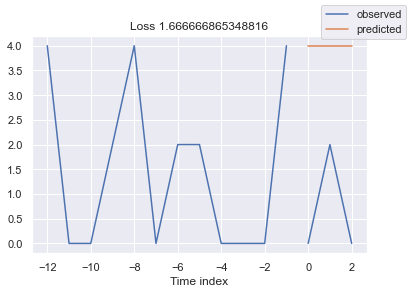

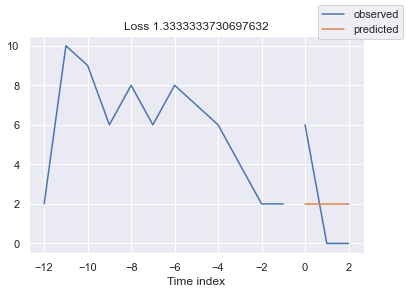

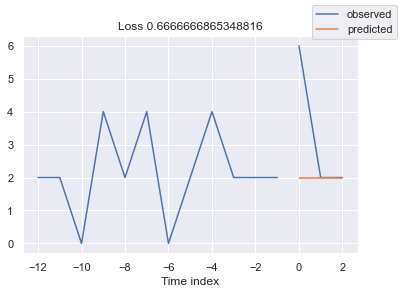

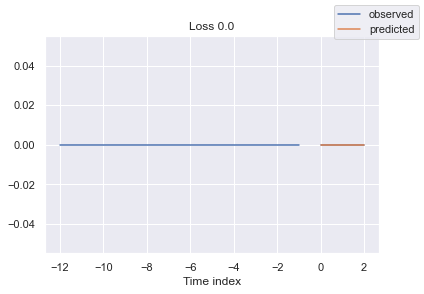

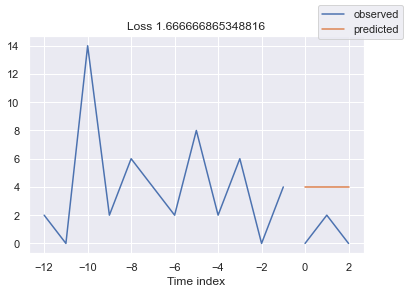

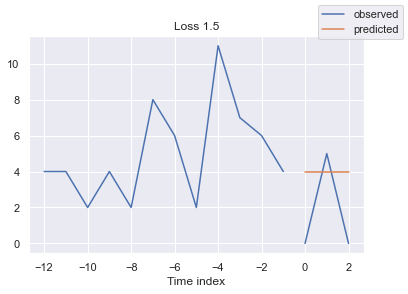

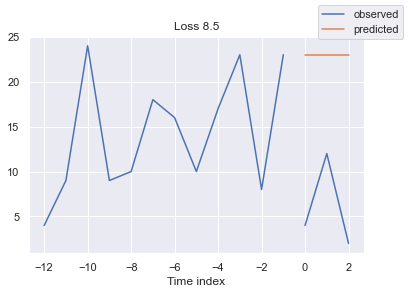

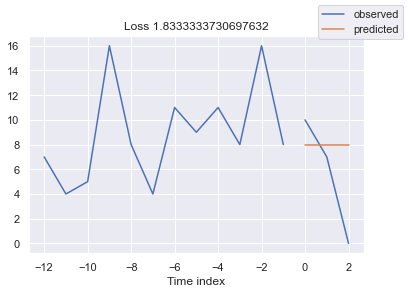

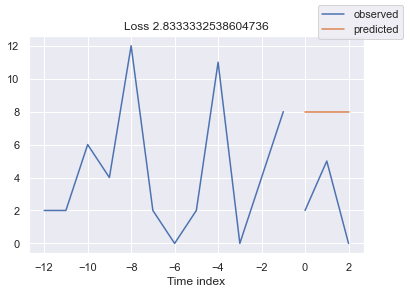

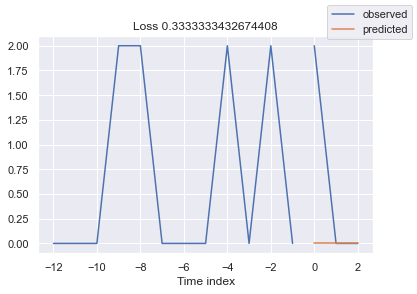

In [38]:
for idx in range(10):  # plot 10 examples
    Baseline().plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True);

### Transformer

### Model Training

In [41]:
# configure network and trainer
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=2, verbose=False, mode="min")

trainer = pl.Trainer(
    max_epochs=5,
    gpus=None,
    weights_summary="top",
    gradient_clip_val=0.1,
    #fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[early_stop_callback],

)


tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.03,
    hidden_size=16,
    attention_head_size=1,
    dropout=0.1,
    hidden_continuous_size=8,
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    reduce_on_plateau_patience=2,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores


Number of parameters in network: 57.0k


In [42]:
3trainer.fit(
    tft,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader,
)


   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 36.6 K
3  | prescalers                         | ModuleDict                      | 128   
4  | static_variable_selection          | VariableSelectionNetwork        | 2.1 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 3.4 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 771   
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | static_context_initial_cell_lstm   | GatedResidualNetwork            | 1.1 

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

Validating: 0it [00:00, ?it/s]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

Validating: 0it [00:00, ?it/s]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

Validating: 0it [00:00, ?it/s]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

Validating: 0it [00:00, ?it/s]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

Validating: 0it [00:00, ?it/s]

AttributeError: module 'tensorflow._api.v2.io.gfile' has no attribute 'get_filesystem'

In [43]:
# calculate mean absolute error on validation set
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = tft.predict(val_dataloader)
(actuals - predictions).abs().mean()

tensor(2.7411)

In [44]:
# raw predictions are a dictionary from which all kind of information including quantiles can be extracted
raw_predictions, x = tft.predict(val_dataloader, mode="raw", return_x=True)

In [52]:
actuals

tensor([[ 0.,  2.,  0.],
        [ 6.,  0.,  0.],
        [ 6.,  2.,  2.],
        ...,
        [ 3.,  4.,  0.],
        [12., 22.,  3.],
        [ 0.,  0.,  0.]])

In [48]:
SMAPE()(predictions, actuals)

tensor(1.5657)

In [50]:
predictions

tensor([[0.9957, 1.2542, 1.0552],
        [5.4086, 5.9069, 5.7291],
        [1.7697, 2.1510, 2.0389],
        ...,
        [2.5893, 3.1847, 3.0053],
        [7.2795, 8.4911, 7.3978],
        [0.0950, 0.0641, 0.1027]])

### View Worst Performers compared to real output

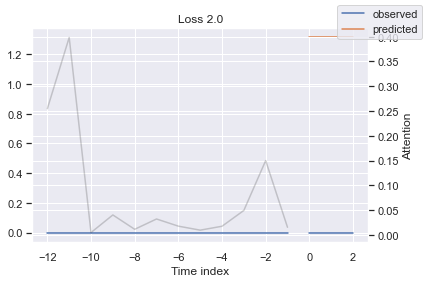

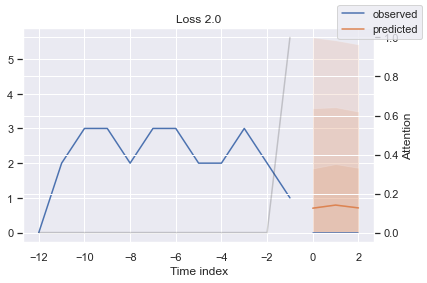

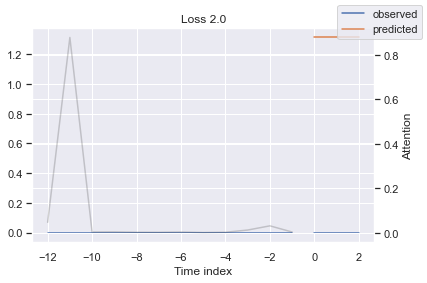

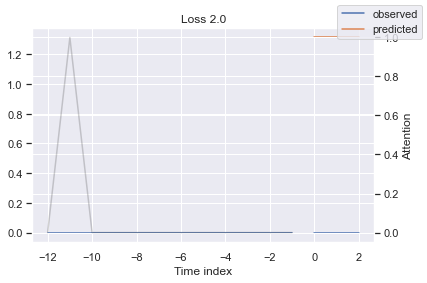

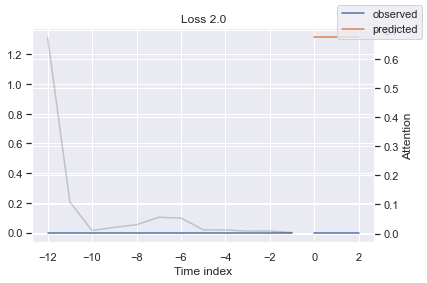

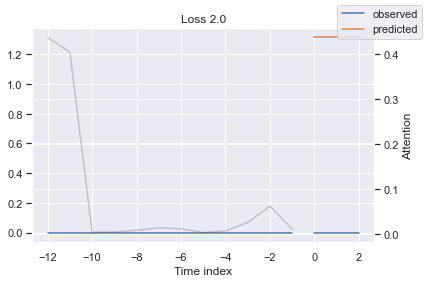

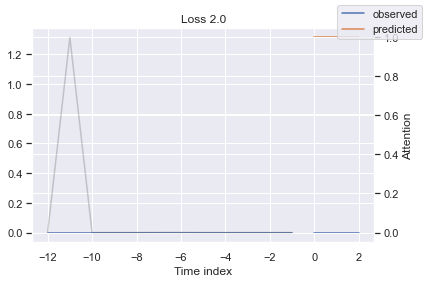

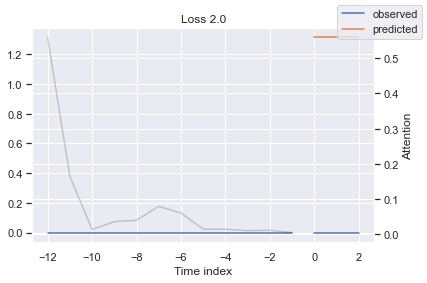

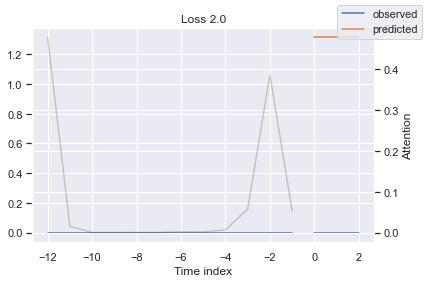

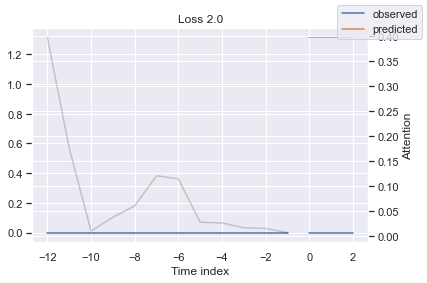

In [46]:
# calcualte metric by which to display
predictions = tft.predict(val_dataloader)
mean_losses = SMAPE(reduction="none")(predictions, actuals).mean(1)
indices = mean_losses.argsort(descending=True)  # sort losses
for idx in range(10):  # plot 10 examples
    tft.plot_prediction(
        x, raw_predictions, idx=indices[idx], add_loss_to_title=SMAPE(quantiles=tft.loss.quantiles)
    );

#### plotting additional values

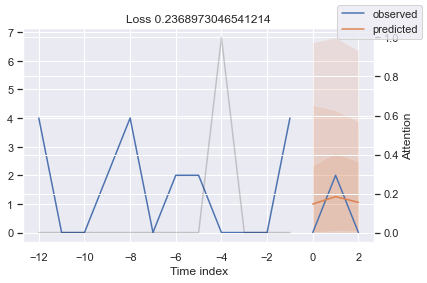

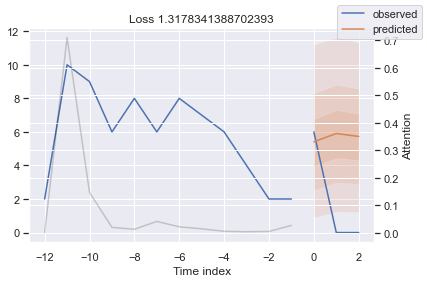

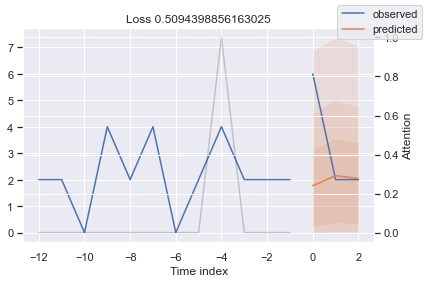

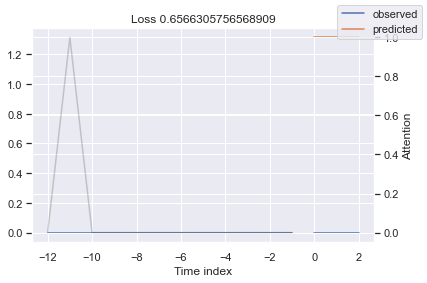

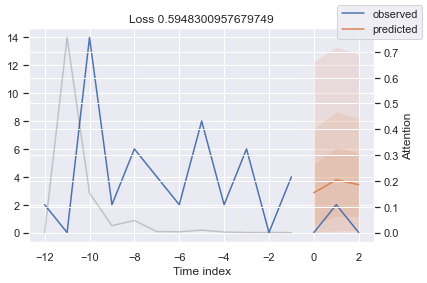

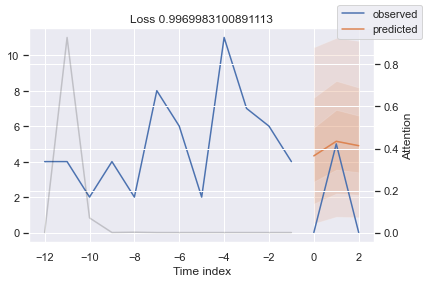

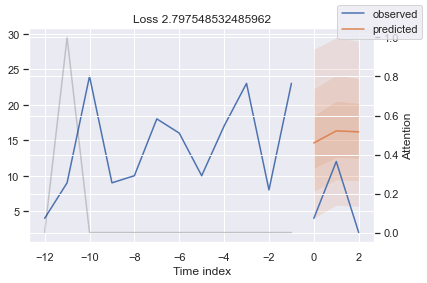

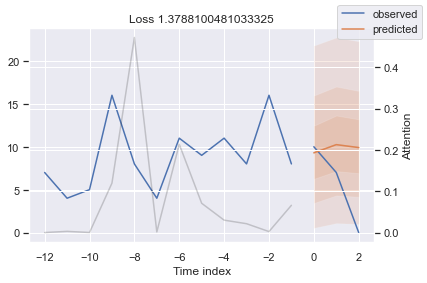

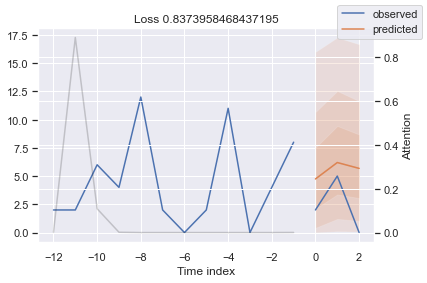

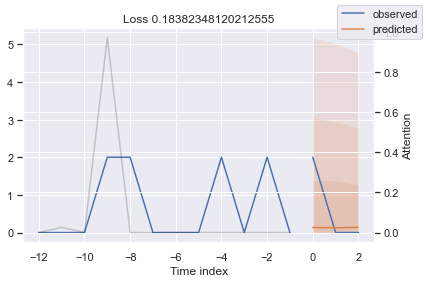

In [57]:
#random predictions

for idx in range(10):  # plot 10 examples
    tft.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True);

### Predictions by Variable compared to real outputs

{'encoder_length': <Figure size 720x360 with 2 Axes>,
 'Value_units_center': <Figure size 720x360 with 2 Axes>,
 'Value_units_scale': <Figure size 720x360 with 2 Axes>,
 'relative_time_idx': <Figure size 720x360 with 2 Axes>,
 'Value_units': <Figure size 720x360 with 2 Axes>,
 'log_units_sold': <Figure size 720x360 with 2 Axes>,
 'avg_sales_of_POS': <Figure size 720x360 with 2 Axes>,
 'avg_sales_of_Prod_Name': <Figure size 720x360 with 2 Axes>,
 'Point-of-Sale_ID': <Figure size 720x360 with 2 Axes>,
 'ProductName_ID': <Figure size 720x360 with 2 Axes>,
 'month': <Figure size 720x360 with 2 Axes>,
 'year': <Figure size 432x288 with 2 Axes>}

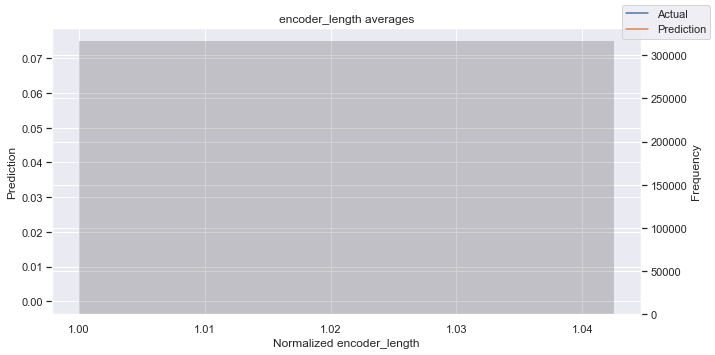

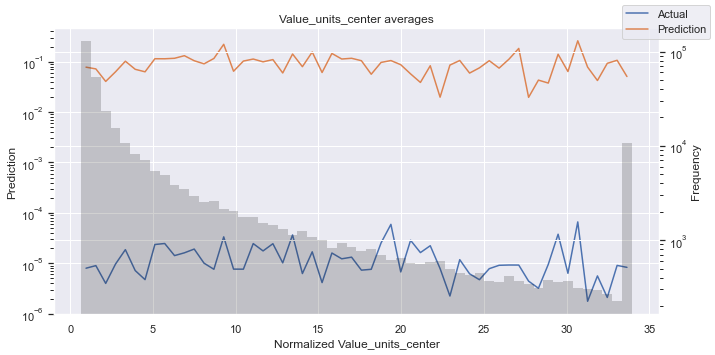

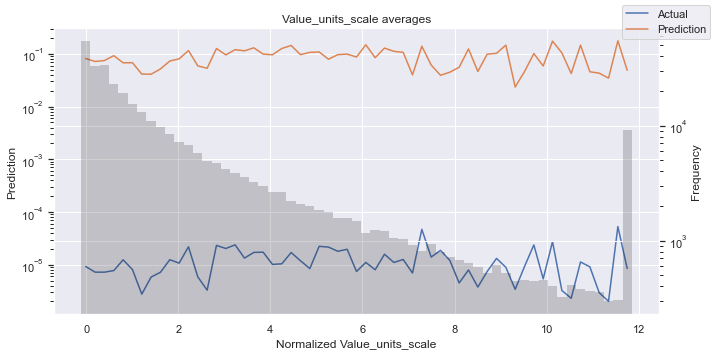

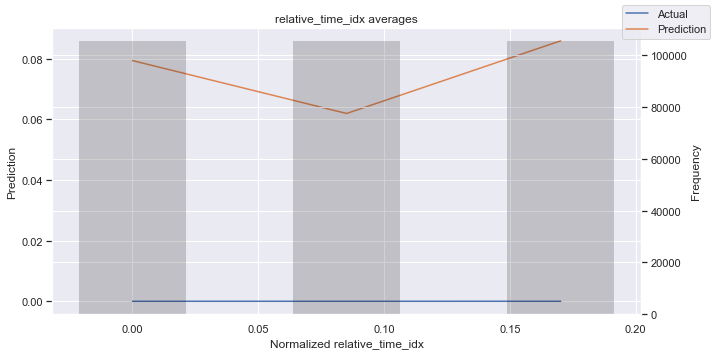

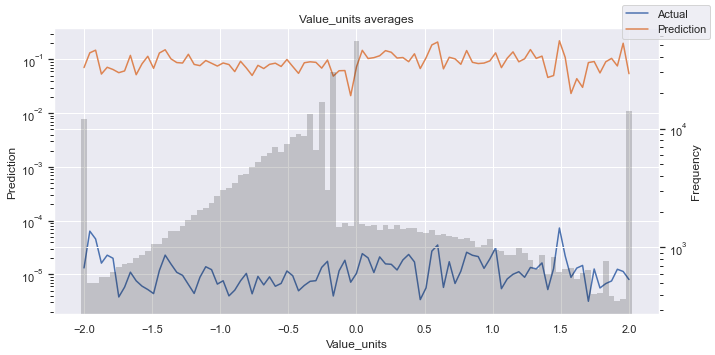

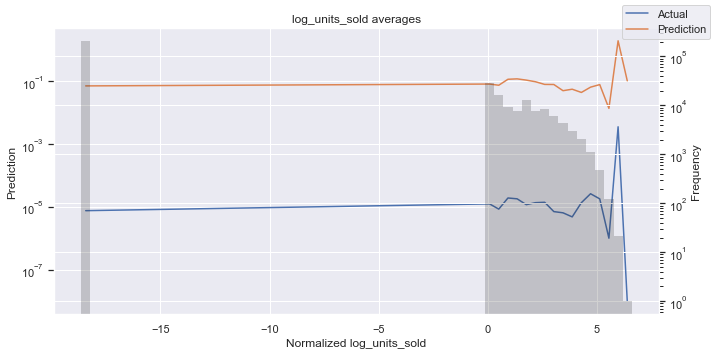

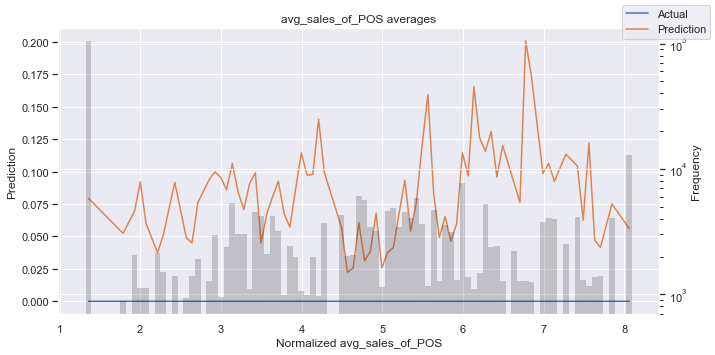

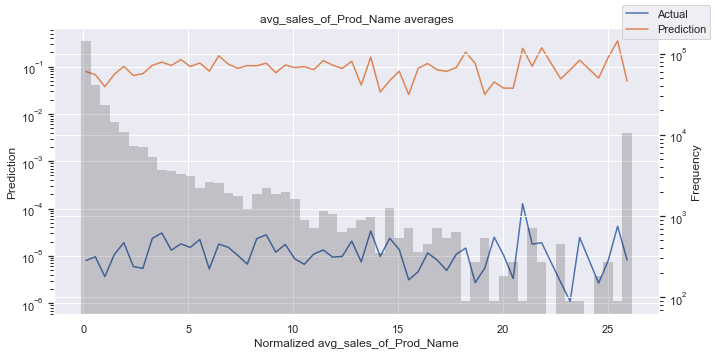

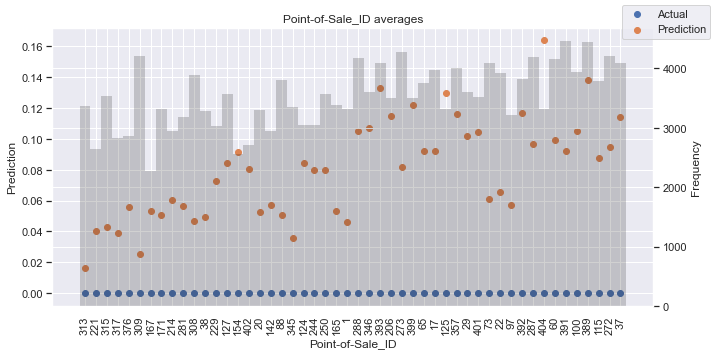

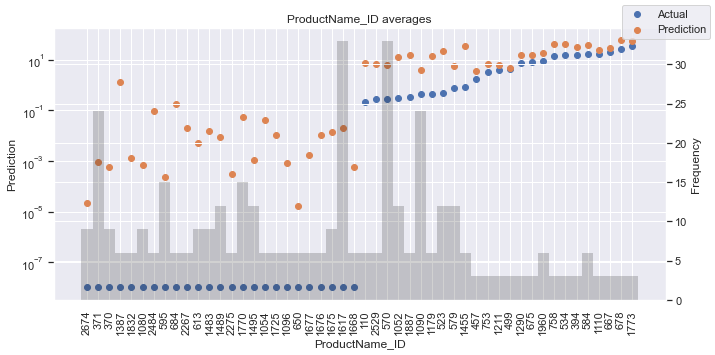

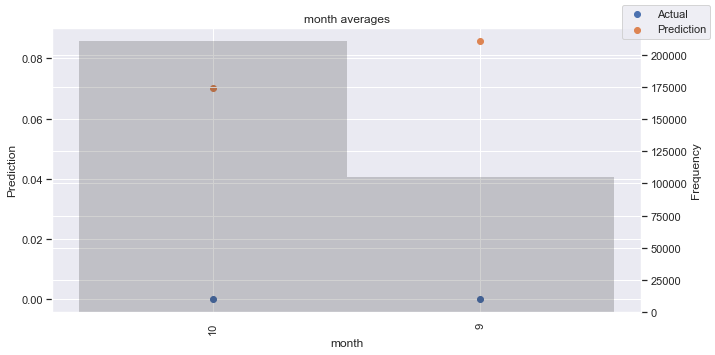

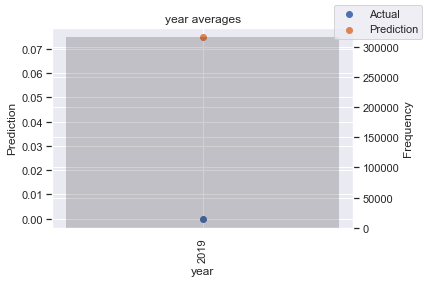

In [110]:
predictions, x = tft.predict(val_dataloader, return_x=True)
predictions_vs_actuals = tft.calculate_prediction_actual_by_variable(x, predictions)
tft.plot_prediction_actual_by_variable(predictions_vs_actuals)

#### Check Behavior on one particular store -> use on the sampled list:

In [62]:
#stores in sample
include_ids

array(['333', '402', '206', '65', '317', '167', '232', '399', '317',
       '125', '392', '126', '79', '199', '374', '389', '202', '357',
       '160', '287', '210', '69', '355', '142', '233', '17', '264', '60',
       '88', '250', '22', '250', '315', '273', '168', '404', '51', '221',
       '393', '281', '195', '391', '168', '13', '370', '137', '20', '399',
       '76', '25', '308', '352', '37', '401', '38', '313', '346', '281',
       '158', '244', '171', '309', '327', '68', '374', '2', '124', '29',
       '227', '115', '100', '37', '272', '393', '330', '349', '208',
       '161', '239', '121', '250', '345', '214', '113', '73', '133',
       '288', '60', '154', '245', '127', '97', '376', '1', '75', '229',
       '311', '242', '190', '165'], dtype=object)

### Testing predictions

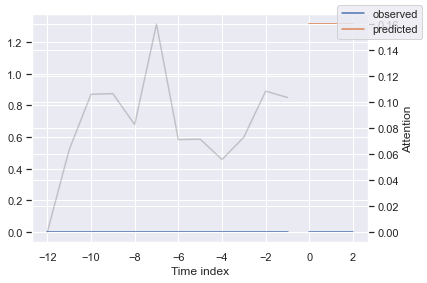

In [109]:
raw_prediction, x = tft.predict(
    training.filter(lambda x: (x['Point-of-Sale_ID'] == "171") & (x.ProductName_ID == "9")),
    mode="raw",
    return_x=True,
)
tft.plot_prediction(x, raw_prediction, idx=0);

#### Editorial option

Our limitations for training led us to use bi-weekly data. Given the range in our dates, we now have reached a point where leaving the last observation (30-10-2019) will hinder our predictive ability.

1. Each date represents the sales for the 2 weeks after the date.
2. Given that our dataset finishes at date 04/11 - keeping this as a valuid observation for future data would consider that the sales made in 1/3 of the time as the full range.

In [218]:
#make backup of date series
copy = date_series[:]

In [212]:
date_series.drop(date_series.tail(1).index,inplace=True) # drop last rows from our indexer

In [213]:
#drop last date - whose time_idx was 34
grouped_data = grouped_data.loc[grouped_data['time_idx'] < 34]

### Getting Predictions on new, unseen data
AS with most of the interactions with pytorch-forecasting package, we refer to the tutorial for the general workings of the package, with the necessary adjustments for everything to work seamlessly with our data

https://pytorch-forecasting.readthedocs.io/en/latest/tutorials/stallion.html

In [215]:
# select last 12 semimonths from data (max_encoder_length is 12)
encoder_data = grouped_data[lambda x: x.time_idx > x.time_idx.max() - max_encoder_length]

# select last known data point and create decoder data from it
# iwe should not just forward fill the covariates but specify them in order to account to account for any known change
last_data = grouped_data[lambda x: x.time_idx == x.time_idx.max()]
decoder_data = pd.concat(
    [last_data.assign(Date=lambda x: x.Date + pd.offsets.Week(2*i)) for i in range(1, max_prediction_length + 1)],
    ignore_index=True,
)

#reconverts time index. please save a copy of date_series before running this cell -> run once cell
decoder_data.drop('time_idx', inplace = True, axis = 1)
date_series = date_series.append(pd.Series(decoder_data['Date'].unique()), ignore_index = True)
date_series.index = np.arange(1, len(date_series) + 1)

#we now merge dfs on dates
to_merge = date_series.to_frame().reset_index().rename(columns = {0: 'Date'})

## add time index consistent with "data"
decoder_data = decoder_data.merge(to_merge, on = 'Date', how = 'inner')
decoder_data.rename(columns = {'index': "time_idx"}, inplace = True)

## adjust additional time feature(s)
decoder_data["month"] = decoder_data.Date.dt.month.astype(str).astype("category")  # categories have be strings

# combine encoder and decoder data
new_prediction_data = pd.concat([encoder_data, decoder_data], ignore_index=True)

In [216]:
new_prediction_data

,Point-of-Sale_ID,ProductName_ID,Date,Value_units,month,year,log_units_sold,avg_sales_of_POS,avg_sales_of_Prod_Name,time_idx
0,1,4,2019-04-30,0.0,4,2019,-18.420681,6.448961,0.862275,22
1,1,5,2019-04-30,0.0,4,2019,-18.420681,6.448961,0.195122,22
2,1,6,2019-04-30,2.0,4,2019,0.693147,6.448961,1.427848,22
3,1,14,2019-04-30,4.0,4,2019,1.386294,6.448961,7.982927,22
4,1,15,2019-04-30,2.0,4,2019,0.693147,6.448961,1.623441,22
...,...,...,...,...,...,...,...,...,...,...
1579540,404,2845,2019-11-26,15.0,11,2019,2.708050,8.877034,11.068293,36
1579541,404,2846,2019-11-26,5.0,11,2019,1.609438,8.877034,17.882927,36
1579542,404,2847,2019-11-26,124.0,11,2019,4.820282,8.877034,38.200000,36
1579543,404,2848,2019-11-26,0.0,11,2019,-18.420681,8.877034,0.360335,36


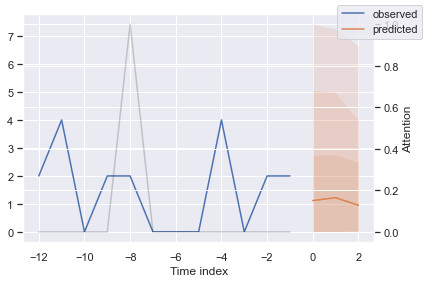

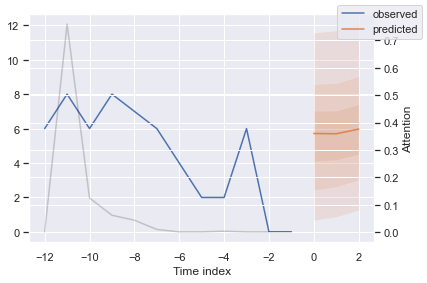

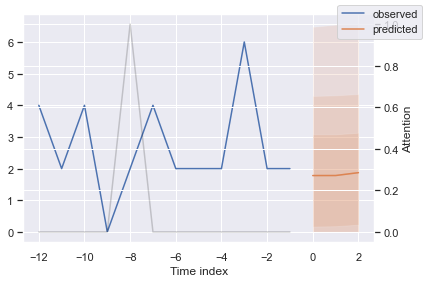

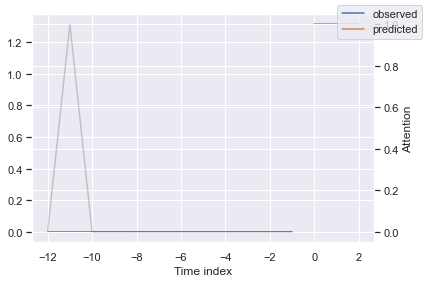

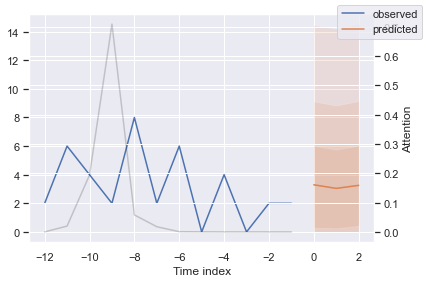

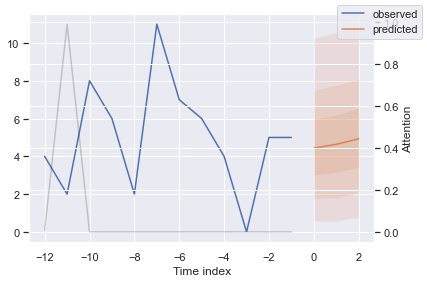

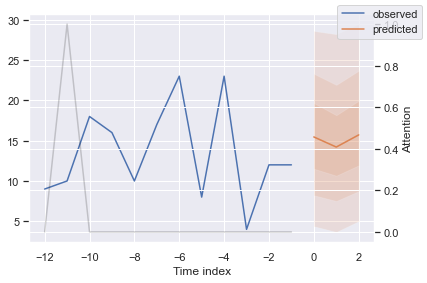

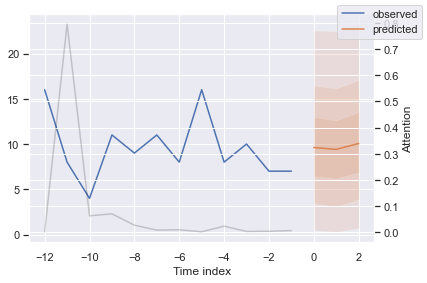

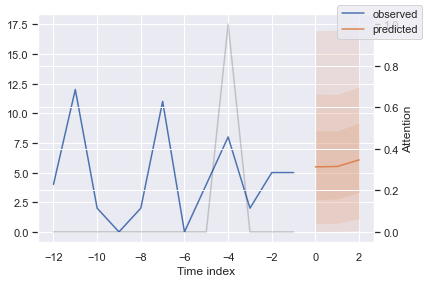

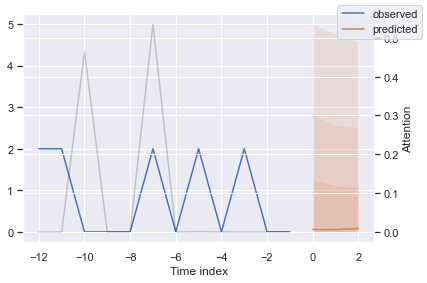

In [203]:
new_raw_predictions, new_x = tft.predict(new_prediction_data, mode="raw", return_x=True)

for idx in range(10):  # plot 10 examples
    tft.plot_prediction(new_x, new_raw_predictions, idx=idx, show_future_observed=False);

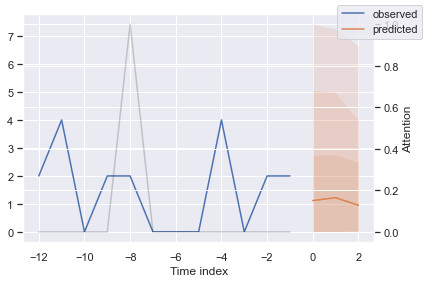

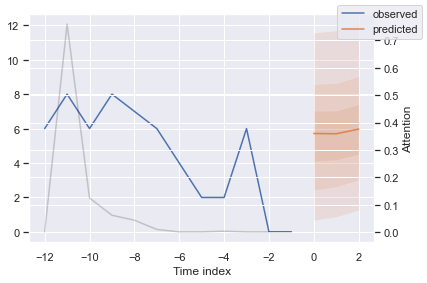

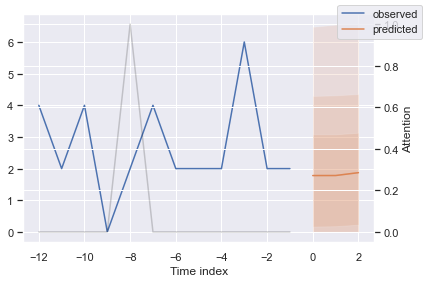

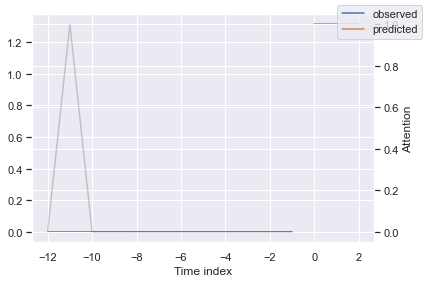

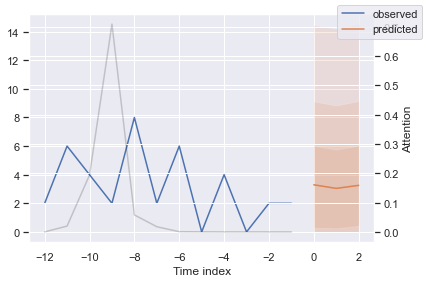

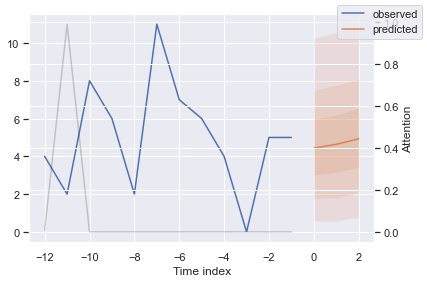

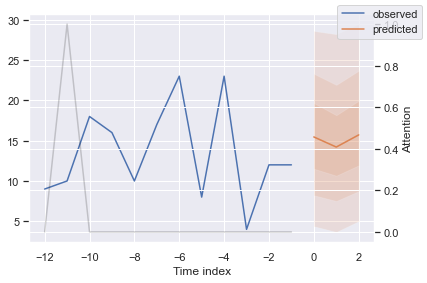

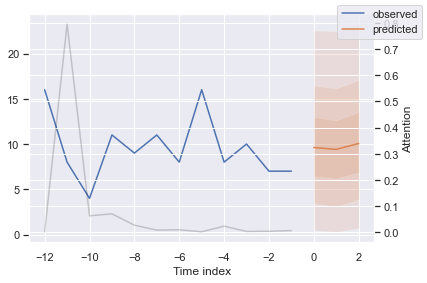

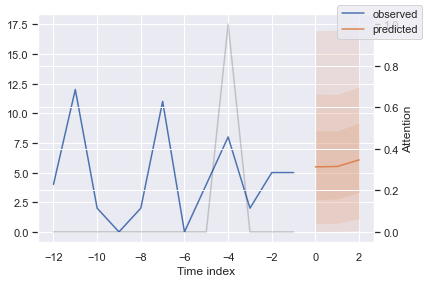

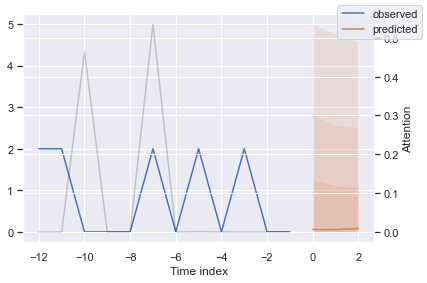

In [204]:
new_raw_predictions, new_x = tft.predict(new_prediction_data, mode="raw", return_x=True)

for idx in range(10):  # plot 10 examples
    tft.plot_prediction(new_x, new_raw_predictions, idx=idx, show_future_observed=False);

### Other points of Interest

1. Explanatory power of features

{'attention': <Figure size 432x288 with 1 Axes>,
 'static_variables': <Figure size 504x234 with 1 Axes>,
 'encoder_variables': <Figure size 504x270 with 1 Axes>,
 'decoder_variables': <Figure size 504x198 with 1 Axes>}

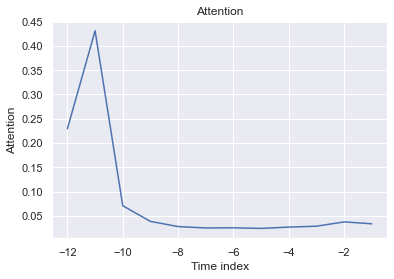

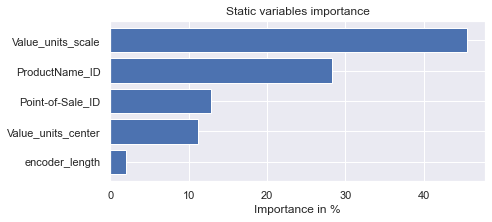

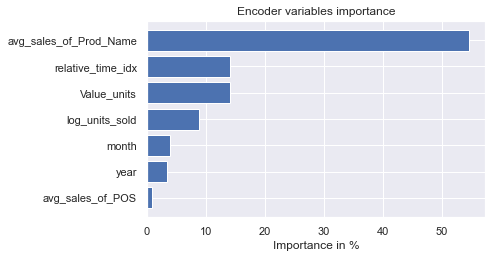

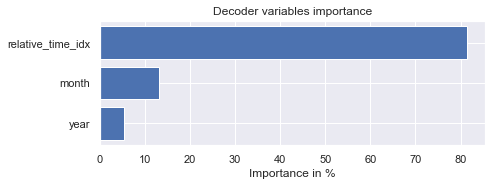

In [102]:
#Identifying which features have the most explanatory power by making use of the library's functionalities

interpretation = tft.interpret_output(raw_predictions, reduction="sum")
tft.plot_interpretation(interpretation)

### Store stuff with pickle to run on other DFs

In [219]:
import pickle

quant_Transf = 'QT_tft.sav'
pickle.dump(tft, open(quant_Transf, 'wb'))

tft_training = 'tft_training.sav'
pickle.dump(training, open(tft_training, 'wb'))

tft_val = 'tft_val.sav'
pickle.dump(validation, open(tft_val, 'wb'))

new_data_solving =  'new_prediction_data.sav'
pickle.dump(new_prediction_data, open(new_data_solving, 'wb'))